In [10]:
import subprocess
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
import pandas as pd
from tqdm import tqdm

In [11]:
# architecture parameters
@dataclass
class arch:
    warps: int = 1
    cores: int = 1
    threads: int = 1
# running parameters 
@dataclass
class run:
    arch: arch
    kernel: str
    driver: str = "simx"
    args: dict = field(default_factory=dict)

In [12]:
path_to_vortex = "/home/jblab/ivan_khromov/release/vortex"
tile_size = 'TS'
work_per_thread = 'WPT'
width = 'WIDTH'

In [13]:
def error_running (run_params: run, error_text: str) -> str:
    return f"error in running in {run_params.kernel} : warps={run_params.arch.warps} cores={run_params.arch.cores} threads={run_params.arch.threads}" \
         f" driver={run_params.driver} args=-N{run_params.args['N']} -M{run_params.args['M']} -K{run_params.args['K']} error message - {error_text}/n"

In [14]:
def error_verification (run_params: run, number_of_errors: str) -> str:
    return f"error in verifing results {run_params.kernel} : warps={run_params.arch.warps} cores={run_params.arch.cores} threads={run_params.arch.threads}" \
        f" driver={run_params.driver} args=-N{run_params.args['N']} -M{run_params.args['M']} -K{run_params.args['K']} Number of errors : {number_of_errors}'\n'"   

In [15]:
def create_common_h (params: dict, kernel_name: str):
    file_name = f"{path_to_vortex}/tests/opencl/{kernel_name}/common.h"
    with open(file_name, 'w') as file:
        text = "#ifndef COMMON_H\n" + "#define COMMON_H\n" + "\n" 
        if tile_size in params:
            text += f"#define TS {params[tile_size]}\n"
        if work_per_thread in params:
            text += f"#define WPT {params[work_per_thread]}\n"
            text += "#define RTS (TS/WPT)\n"
        if width in params:
            text += f"#define WIDTH {params[width]}\n"
        text += '\n' +  "#endif // COMMON_H"
        file.write(text)
    # open main.cc file to recompile before run with new common.h
    with open(f"{path_to_vortex}/tests/opencl/{kernel_name}/main.cc", 'a') as main:
        main.write('')

In [16]:
def perf (run_params: run, path_to_output_file: str) -> pd.DataFrame:
    # run kernel
    vortex = f"--warps={run_params.arch.warps} --cores={run_params.arch.cores} --threads={run_params.arch.threads}"
    run_args = f"-N{run_params.args['N']} -M{run_params.args['M']} -K{run_params.args['K']}"
    command = f"cd {path_to_vortex}/build && ./ci/blackbox.sh {vortex} --driver={run_params.driver} --app={run_params.kernel} --args=\"{run_args}\""
    print(command)
    subprocess.call(f"{command} > {path_to_output_file}", shell=True)

    # collect statistic 
    with open(path_to_output_file, 'r') as file:
        lines = file.readlines()
    error_message = ""
    general_perf_stat = ""
    for line in lines:
        if "PERF:" in line:
            general_perf_stat = line
        # check for errors
        if "FAILED" in line: 
            error_message = error_verification(run_params, line[line.find("FAILED! - "):])
        if "Error" in line:
            error_message = error_running(run_params, line[line.find("Error:"):])
    # pars string with general perf statistic of running kernel
    pairs = general_perf_stat.replace("PERF: ", "").split(", ")
    perf_dict = {key_value.split("=")[0]: float(key_value.split("=")[1]) for key_value in pairs}
    if perf_dict["cycles"] <= 0:
        error_message = error_running(run_params, "Invalid number of cycles")
    # write result to data frame
    run_result = pd.DataFrame([{"kernel": run_params.kernel[-1], "driver": run_params.driver, "cores": run_params.arch.cores, 
                 "warps": run_params.arch.warps, "threads": run_params.arch.threads, "M": run_params.args["M"], 
                 "N": run_params.args["N"], "K": run_params.args["K"], "instrs": perf_dict["instrs"], "cycles": perf_dict["cycles"],
                 "IPC": perf_dict["IPC"], "error": error_message}])
    return run_result

In [17]:
def draw (data_frame: pd.DataFrame, x_label: str, y_label: str, title: str, path: str):
    data_frame.plot(kind = "bar", x = x_label, y = y_label)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.savefig(path)

  0%|          | 0/4 [00:00<?, ?it/s]

cd /home/jblab/ivan_khromov/release/vortex/build && ./ci/blackbox.sh --warps=4 --cores=4 --threads=4 --driver=simx --app=kernel1 --args="-N16 -M16 -K16"


 25%|██▌       | 1/4 [00:00<00:02,  1.12it/s]

cd /home/jblab/ivan_khromov/release/vortex/build && ./ci/blackbox.sh --warps=4 --cores=4 --threads=4 --driver=simx --app=kernel2 --args="-N16 -M16 -K16"


 50%|█████     | 2/4 [00:01<00:01,  1.14it/s]

cd /home/jblab/ivan_khromov/release/vortex/build && ./ci/blackbox.sh --warps=4 --cores=4 --threads=4 --driver=simx --app=kernel3 --args="-N16 -M16 -K16"


 75%|███████▌  | 3/4 [00:02<00:00,  1.13it/s]

cd /home/jblab/ivan_khromov/release/vortex/build && ./ci/blackbox.sh --warps=4 --cores=4 --threads=4 --driver=simx --app=kernel4 --args="-N16 -M16 -K16"


100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


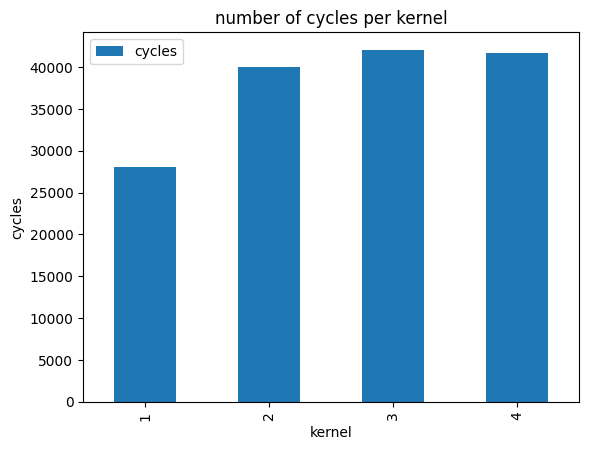

In [18]:
# create common.h files for each kernel
params1 = {
    tile_size: 4
}
create_common_h(params1, "kernel1")
create_common_h(params1, "kernel2")

params3 = {
    tile_size: 4,
    work_per_thread: 4
}
create_common_h(params3, "kernel3")

params4 = {
    tile_size: 8,
    width: 4
}
create_common_h(params4, "kernel4")

# fill running params data class for each kernel
run_p = []
arg = {
    "M": 16,
    "N": 16,
    "K": 16
}
arch_p = arch(threads=4, cores=4, warps=4)
run_p.append(run(arch_p, kernel="kernel1", driver="simx", args=arg))
run_p.append(run(arch_p, kernel="kernel2", driver="simx", args=arg))
run_p.append(run(arch_p, kernel="kernel3", driver="simx", args=arg))
run_p.append(run(arch_p, kernel="kernel4", driver="simx", args=arg))

# run all kernels and collect statistic in data frame
data_frames = []
output_file = f"{path_to_vortex}/tests/opencl/j_stat/output.txt"
for params in tqdm(run_p):
    data_frames.append(perf(params, output_file))
data_frame = pd.concat(data_frames, ignore_index=True)

# draw graph based on the recived statistic
draw(data_frame, "kernel", "cycles", "number of cycles per kernel", "graphics/graph.png")